In [ ]:
# !wget https://dataverse.harvard.edu/api/access/datafile/3107210?format=tab&gbrecs=true


--2021-12-24 11:40:04--  https://dataverse.harvard.edu/api/access/datafile/3107210?format=tab
Resolving dataverse.harvard.edu (dataverse.harvard.edu)... 35.175.164.183, 52.70.216.144, 107.20.115.215
Connecting to dataverse.harvard.edu (dataverse.harvard.edu)|35.175.164.183|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 291997192 (278M) [text/tab-separated-values]
Saving to: ‘3107210?format=tab.1’

3107210?format=tab. 100%[===================>] 278.47M  83.8MB/s    in 3.3s    

2021-12-24 11:40:08 (83.8 MB/s) - ‘3107210?format=tab.1’ saved [291997192/291997192]



In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import random
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

from scipy.spatial.distance import jensenshannon
from scipy.special import kl_div


from tqdm.notebook import tqdm, trange

In [2]:
df=pd.read_csv('world_polls.csv',sep='\t')
keys_cols=['polldate', 'election',	'system',	'rule',	'round','electionyr','elecdate']

In [3]:
def entropy(p,q):
  return - p*np.log(q)
  
def mse(y_true,y_pred):
  return np.square(y_pred-y_true)

def mae(y_true,y_pred):
  return np.abs(y_pred-y_true)

def error_p(p,n):
  return 1.96*np.sqrt(p*(1-p)/n)

def diff_error(p,q,n):
  err_th=error_p(p,n)
  err_obs=np.abs(p-q)
  return err_obs-err_th

def odd_err(p,v):
  return np.abs(np.log((p/(1-p))*(1-v)/v))

def extract(df,id_poll):
  sondage=df[df.idpoll==id_poll]
  return sondage.vote_,sondage.poll_, sondage.idpoll

In [4]:
def generate_id_poll(df_source,k_cols):
  df=df_source.copy()
  df['idpoll']=0
  keys=df[k_cols].drop_duplicates( ignore_index=True)
  print(f'Nombre de clefs {len(keys)}')
  for i in trange(len(keys)):
    filter=(df[keys_cols] ==keys[keys_cols].iloc[i]).sum(axis=1)==7
    df.loc[filter,'idpoll']=i
  return df

df=df[df.vote_.isna()==False]
df=df[df.poll_.isna()==False] 
df=generate_id_poll(df,keys_cols)

Nombre de clefs 23931


  0%|          | 0/23931 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
df.to_pickle("polls.p")

In [5]:
df=pd.read_pickle("polls.p")
df=df[df["sample"]>0]

# df=df[df.yr>1995]
# df=df[df.daysbeforeED<14]

In [6]:
df

,polldate,election,system,rule,round,electionyr,elecdate,turnout,enpp,daysbeforeED,...,npolls,pollcycle,partyid,countryid,espv,regime,yr,electionid,country,idpoll
2084,1943-07-31,Legislative,Parliamentary,SMDP,1.0,1943.0,1943-08-21,96.320000,2.839419,21.0,...,1.0,21.0,1.0,2.0,Candidate,Old,1943.0,1943.1,Australia,0
2085,1943-07-31,Legislative,Parliamentary,SMDP,1.0,1943.0,1943-08-21,96.320000,2.839419,21.0,...,1.0,21.0,2.0,2.0,Candidate,Old,1943.0,1943.1,Australia,0
4352,1946-09-07,Legislative,Parliamentary,SMDP,1.0,1946.0,1946-09-28,93.970001,2.284524,21.0,...,1.0,21.0,1.0,2.0,Candidate,Old,1946.0,1946.1,Australia,1
4353,1946-09-07,Legislative,Parliamentary,SMDP,1.0,1946.0,1946-09-28,93.970001,2.284524,21.0,...,1.0,21.0,2.0,2.0,Candidate,Old,1946.0,1946.1,Australia,1
4380,1946-09-21,Legislative,Parliamentary,SMDP,1.0,1946.0,1946-09-28,93.970001,2.284524,7.0,...,1.0,21.0,1.0,2.0,Candidate,Old,1946.0,1946.1,Australia,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1511758,2016-06-29,Legislative,Parliamentary,SMDP,1.0,2016.0,2016-07-02,91.000000,NaN,3.0,...,1.0,NaN,2.0,2.0,Candidate,Old,2016.0,2016.1,Australia,23755
1511759,2016-06-29,Legislative,Parliamentary,SMDP,1.0,2016.0,2016-07-02,91.000000,NaN,3.0,...,1.0,NaN,4.0,2.0,Candidate,Old,2016.0,2016.1,Australia,23755
1511760,2016-06-30,Legislative,Parliamentary,SMDP,1.0,2016.0,2016-07-02,91.000000,NaN,2.0,...,1.0,NaN,1.0,2.0,Candidate,Old,2016.0,2016.1,Australia,23756
1511761,2016-06-30,Legislative,Parliamentary,SMDP,1.0,2016.0,2016-07-02,91.000000,NaN,2.0,...,1.0,NaN,2.0,2.0,Candidate,Old,2016.0,2016.1,Australia,23756


## Compute entropy


In [10]:
def poll_measure(df:pd.DataFrame,measure=entropy)->float:
  """
  df should store only one polls
  """
  y=df.vote_.to_numpy()/100
  yhat=df.poll_.to_numpy()/100
  if y.sum()<1:
    y=np.append(y,1-y.sum())
    yhat=np.append(yhat,1-yhat.sum())
    yhat[yhat<0]=0
  yhat[yhat==0]=0.00001
  return measure(y,yhat).sum()

poll_measure(df[df.idpoll==23756],measure=kl_div)

0.0007810374338687864

## Compute random sample

In [11]:
def random_sample_measure(df:pd.DataFrame,n_samples:int=1000,poll_size:int=None,measure=kl_div)->float:
  """
  df should store only one polls
  """
  y=df.vote_.to_numpy()/100
  if poll_size==None:
    poll_size=int(df['sample'].iloc[0])
  if y.sum()<1:
    y=np.append(y,1-y.sum())
  if y.sum()!=1.0:
    # Proba étrange ne sommant pas à 1
    y=y/y.sum()
  try:
    samples=np.random.choice(list(range(len(y))),size=(n_samples,poll_size),p=y)
  except :
    print(y,y.sum())
    return 0
  samples=np.eye(len(y))[samples]
  yhat=samples.sum(axis=1)
  yhat[yhat==0]=0.00001
  yhat=(yhat.T/yhat.sum(axis=1)).T
  measures=measure(y,yhat).sum(axis=1)
  return np.median(measures)

random_sample_measure(df[df.idpoll==23756],1000,1500,measure=kl_div)

0.000810727370421982

In [ ]:
a=np.random.normal(size=(2,4))
a=a-a.min()
a=a/a.sum(axis=1).reshape(-1,1)
b=np.random.normal(size=(4))
b=b-b.min()
b=b/b.sum(axis=1).reshape(-1,1)
print(a)
print(b)
print(kl_div(a,b))

AxisError: ignored

## Finding best random sampling through minimization

In [13]:
def optimal_size_sample(df:pd.DataFrame,n_samples:int=1000,measure=kl_div)->int:
  sample_size=int(df["sample"].iloc[0])
  lb=1
  ub=sample_size
  y_hat=random_sample_measure(df,poll_size=ub,n_samples=n_samples,measure=measure)
  y=poll_measure(df,measure=measure)
  while y-y_hat<-1e-5 and ub<16*sample_size:
    lb=ub
    ub=ub*2
    y_hat=random_sample_measure(df,poll_size=ub,n_samples=n_samples,measure=measure)
  if y-y_hat>0:
    while ub!=lb and ub!=lb+1:
      n=int((ub+lb)/2)
      y_hat=random_sample_measure(df,poll_size=n,n_samples=n_samples,measure=measure)
      r=y-y_hat
      if r>=0:
        ub=n
      else:
        lb=n
  return ub

optimal_size_sample(df[df.idpoll==23756],1000)

1568

In [14]:
from numpy.core.numeric import ones_like
samples_sizes=[]
for i in tqdm(df.idpoll.unique()):
  poll_df=df[df.idpoll==i]
  year=poll_df.yr.iloc[0]
  country=poll_df.country.iloc[0]
  election=poll_df.election.iloc[0]
  system=poll_df.system.iloc[0]
  daysbeforeED=poll_df.daysbeforeED.iloc[0]
  nb_candidates=len(poll_df)
  if poll_df.vote_.sum()<100:
    nb_candidates+=1
  n=int(poll_df["sample"].iloc[0])

  optimal_kl=optimal_size_sample(poll_df)
  optimal_entropy=optimal_size_sample(poll_df,measure=entropy)
  optimal_mse=optimal_size_sample(poll_df,measure=mse)
  optimal_mae=optimal_size_sample(poll_df,measure=mae)
  samples_sizes.append((i,n,optimal_kl,
                        optimal_entropy,optimal_mse,optimal_mae,
                        year,country,election,system,
                        daysbeforeED,nb_candidates))
best_sample_size=pd.DataFrame(samples_sizes,
                              columns=['id','poll_sample','optimal_kl',
                                       'optimal_entropy','optimal_mse','optimal_mae',
                                       'year','country','election',
                                       'system','daysbeforeED','nb_candidates'])


  0%|          | 0/23442 [00:00<?, ?it/s]

In [ ]:
best_sample_size.to_pickle("bss.p")
bss14=best_sample_size[best_sample_size.daysbeforeED<=14].copy()

## Précision en nombre de tirage aléatoire TCL

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


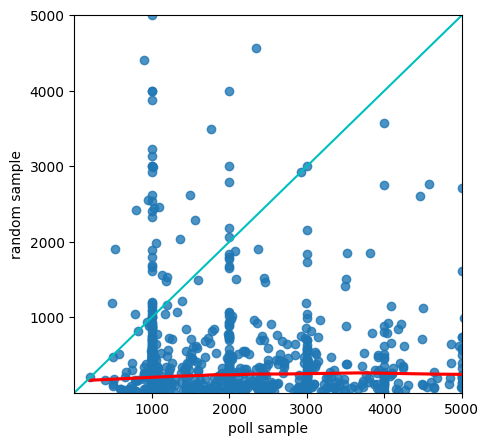

In [ ]:
fig, ax = plt.subplots(figsize=(5,5),dpi=100)
line=list(range(5000))
g=sns.regplot(x='poll sample',y='random sample',
              lowess=True,
              data=bss14,
              ax=ax,
              line_kws={"color": "red"})
# g=sns.regplot(x='poll sample',y='one shot',
#               lowess=True,
#               data=best_sample_size,
#               ax=ax,
#               line_kws={"color": "red"})

plt.plot(line,line,'c')
ax.set_xlim(1, 5000)
ax.set_ylim(1, 5000)
plt.show()

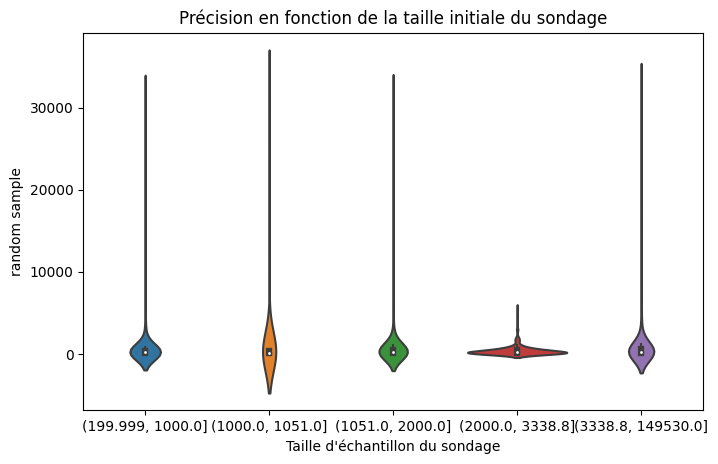

In [ ]:
fig, ax = plt.subplots(figsize=(8,5),dpi=100)
bss14["bins"]=pd.qcut(bss14["poll sample"], 5)
sns.violinplot(x="bins",
               y='random sample',
               data=bss14,
              #  inner="quartile"
            )
# ax.set_ylim(0, 3000)
best_sample_size[best_sample_size['poll sample']==1000].median()
ax.set_xlabel("Taille d'échantillon du sondage")
ax.set_title("Précision en fonction de la taille initiale du sondage")
fig.show()

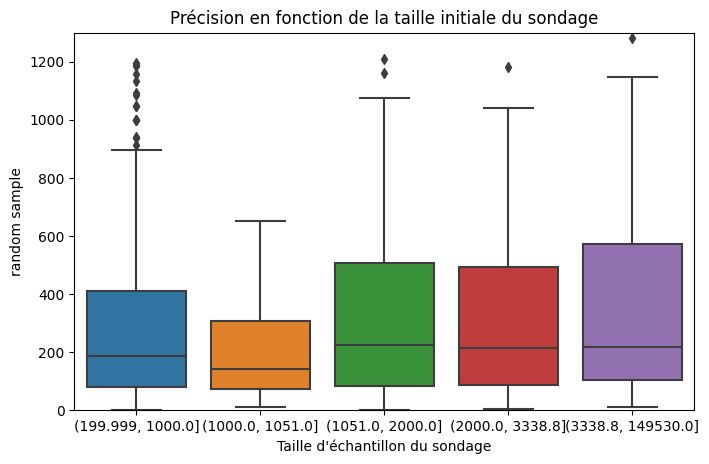

In [ ]:
fig, ax = plt.subplots(figsize=(8,5),dpi=100)
bss14["bins"]=pd.qcut(bss14["poll sample"], 5)
sns.boxplot(x="bins",
            y='random sample',
            data=bss14,
            whis=1.5,              
              #  inner="quartile"
            )
ax.set_ylim(0, 1300)
best_sample_size[best_sample_size['poll sample']==1000].median()
ax.set_xlabel("Taille d'échantillon du sondage")
ax.set_title("Précision en fonction de la taille initiale du sondage")
fig.show()

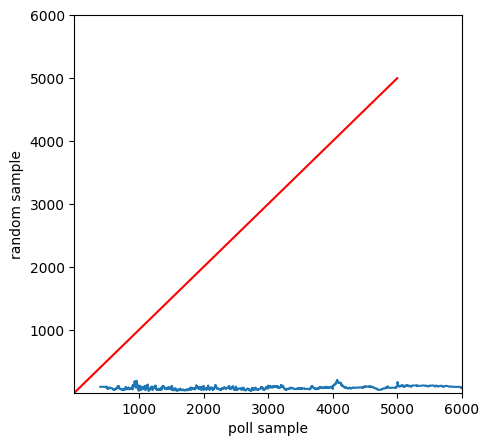

In [ ]:
rolling_best=best_sample_size.sort_values('poll sample').rolling(50).median()

fig, ax = plt.subplots(figsize=(5,5),dpi=100)
sns.lineplot(x='poll sample',y='random sample',data=rolling_best,ax=ax)
plt.plot(line,line,'r')
ax.set_xlim(1, 6000)
ax.set_ylim(1, 6000)
plt.show()

  0%|          | 0/3307 [00:00<?, ?it/s]

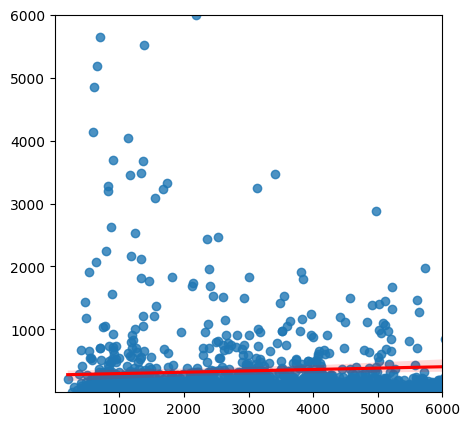

In [ ]:
x=[]
y=[]
for v in tqdm(best_sample_size['poll sample'].unique()):

  x.append(v)
  y.append(best_sample_size[best_sample_size['poll sample']==v]['random sample'].median())

fig, ax = plt.subplots(figsize=(5,5),dpi=100)
sns.regplot(x=x,y=y,
            ax=ax,
            # lowess=True,
            line_kws={"color": "red"})
# plt.plot(line,line,'r')
ax.set_xlim(1, 6000)
ax.set_ylim(1, 6000)
plt.show()

## Précision au cours du temps


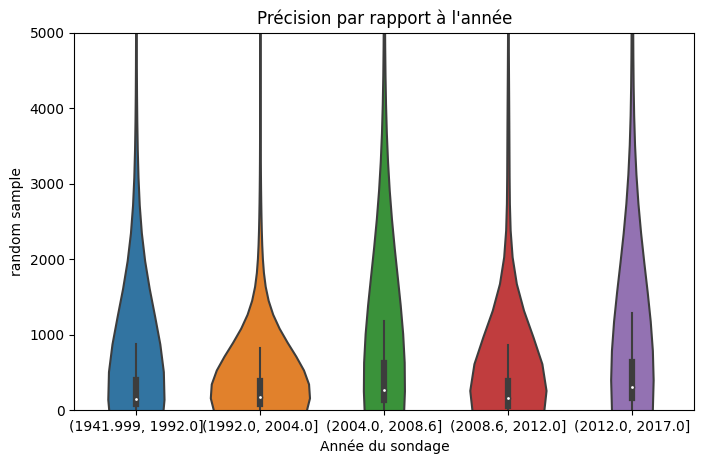

In [ ]:
# fig, ax = plt.subplots(figsize=(5,5),dpi=100)
# # g=sns.regplot(x='year',y='random sample',
# #               lowess=True,
# #               data=bss14,
# #               ax=ax,
# #               line_kws={"color": "red"})
# ax.set_ylim(1, 5000)
# plt.show()
fig, ax = plt.subplots(figsize=(8,5),dpi=100)
bss14["bins"]=pd.qcut(bss14["year"], 5)
sns.violinplot(x="bins",
               y='random sample',
               data=bss14,
              #  inner="quartile"
            )
ax.set_ylim(0, 5000)
ax.set_xlabel("Année du sondage")
ax.set_title("Précision par rapport à l'année")
fig.show()

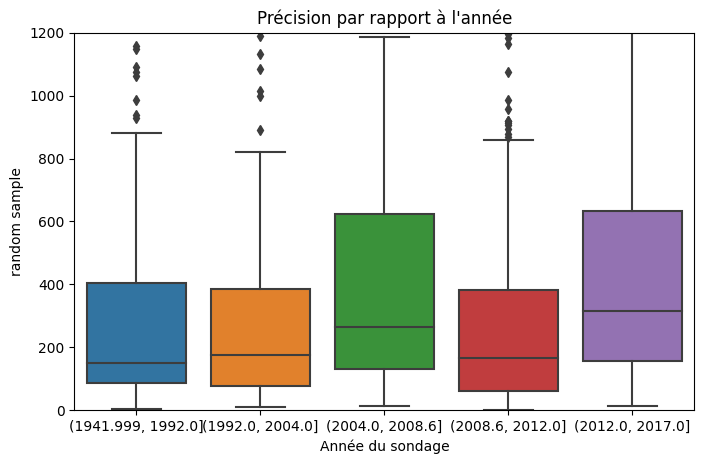

In [ ]:
fig, ax = plt.subplots(figsize=(8,5),dpi=100)
bss14["bins"]=pd.qcut(bss14["year"], 5)
sns.boxplot(x="bins",
               y='random sample',
               data=bss14,
              #  inner="quartile"
            )
ax.set_ylim(0, 1200)
ax.set_xlabel("Année du sondage")
ax.set_title("Précision par rapport à l'année")
fig.show()

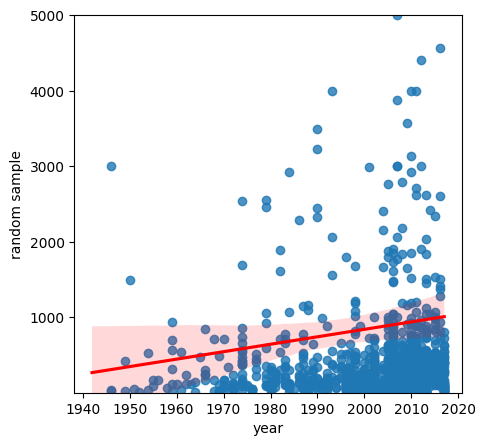

In [ ]:
fig, ax = plt.subplots(figsize=(5,5),dpi=100)
line=list(range(5000))
g=sns.regplot(x='year',y='random sample',
              data=best_sample_size[best_sample_size['daysbeforeED']<14],
              ax=ax,
              line_kws={"color": "red"})
# g=sns.regplot(x='poll sample',y='one shot',
#               lowess=True,
#               data=best_sample_size,
#               ax=ax,
#               line_kws={"color": "red"})

# plt.plot(line,line,'c')
# ax.set_xlim(1, 20000)
ax.set_ylim(1, 5000)
plt.show()

## Précision en fonction de l'écart à la date d'élection

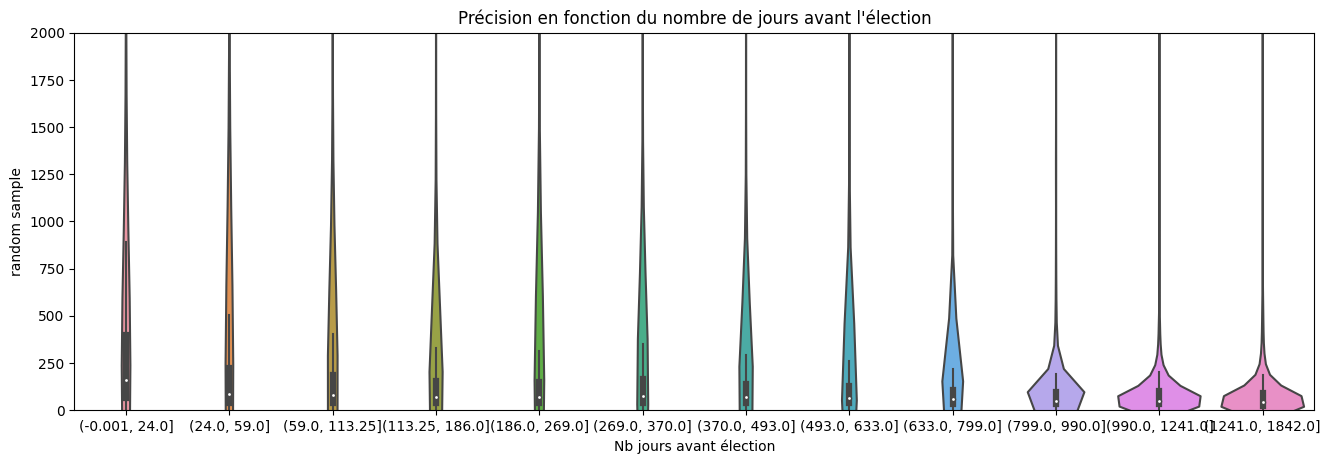

In [ ]:
# fig, ax = plt.subplots(figsize=(5,5),dpi=100)
# line=list(range(5000))
# # g=sns.regplot(x='daysbeforeED',y='random sample',
# #               data=best_sample_size,
# #               ax=ax,
# #               line_kws={"color": "red"})

# # plt.plot(line,line,'c')
# # ax.set_xlim(1, 20000)
# ax.set_ylim(1, 5000)
# plt.show()
fig, ax = plt.subplots(figsize=(16,5),dpi=100)
best_sample_size["bins"]=pd.qcut(best_sample_size["daysbeforeED"], 12)
sns.violinplot(x="bins",
               y='random sample',
               data=best_sample_size
              #  inner="quartile"
            )
ax.set_ylim(0, 2000)
ax.set_xlabel("Nb jours avant élection")
ax.set_title("Précision en fonction du nombre de jours avant l'élection")
fig.show()

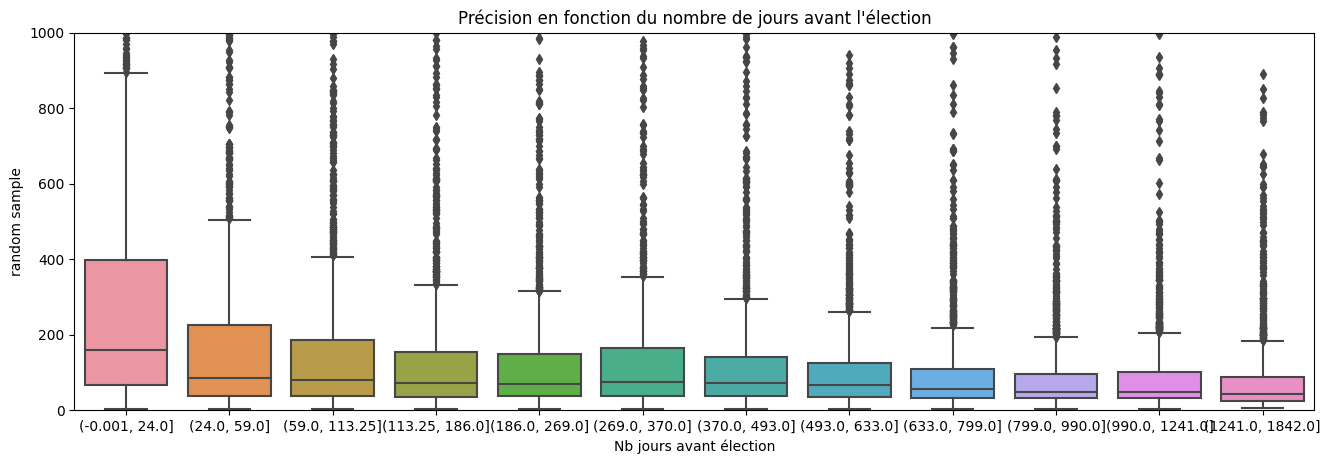

In [ ]:
fig, ax = plt.subplots(figsize=(16,5),dpi=100)
best_sample_size["bins"]=pd.qcut(best_sample_size["daysbeforeED"], 12)
sns.boxplot(x="bins",
               y='random sample',
               data=best_sample_size
              #  inner="quartile"
            )
ax.set_ylim(0, 1000)
ax.set_xlabel("Nb jours avant élection")
ax.set_title("Précision en fonction du nombre de jours avant l'élection")
fig.show()

## Précision en fonction du nombre de partis présentés


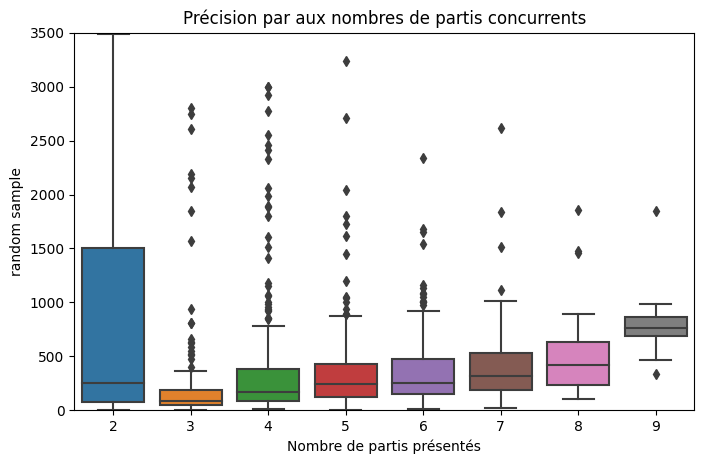

In [ ]:
fig, ax = plt.subplots(figsize=(8,5),dpi=100)
# bss14["bins"]=pd.qcut(bss14["nb_candidates"])
sns.boxplot(x="nb_candidates",
               y='random sample',
               data=bss14,
              #  inner="quartile"
            )
ax.set_ylim(0, 3500)
ax.set_xlabel("Nombre de partis présentés")
ax.set_title("Précision en fonction du nombre de partis concurrents")
fig.show()

## Comparaison avec un tirage aléatoire unique

In [ ]:


def optimal_size_one_shot(df:pd.DataFrame,n_samples:int=1000,measure=kl_div)->int:
  sample_size=int(df["sample"].iloc[0])
  lb=1
  ub=sample_size
  y_hat=random_sample_measure(df,poll_size=ub,n_samples=n_samples,measure=measure)
  y=random_sample_measure(df,poll_size=ub,n_samples=1,measure=measure)
  while y-y_hat<-1e-4:
    lb=ub
    ub=ub*2
    y_hat=random_sample_measure(df,poll_size=ub,n_samples=n_samples,measure=measure)
  if y-y_hat>0:
    while ub!=lb and ub!=lb+1:
      n=int((ub+lb)/2)
      y_hat=random_sample_measure(df,poll_size=n,n_samples=n_samples,measure=measure)
      r=y-y_hat
      if r>=0:
        ub=n
      else:
        lb=n
  return ub

In [ ]:
best_sample_size[best_sample_size['random sample']>=best_sample_size['poll sample']]

,id,poll sample,random sample,year,country,election,system,daysbeforeED,nb_candidates,bins
43,43,1452,3350,1963.0,Australia,Legislative,Parliamentary,22.0,3,"(-0.001, 24.0]"
62,62,1695,2703,1974.0,Australia,Legislative,Parliamentary,93.0,3,"(59.0, 113.25]"
63,63,1810,13492,1974.0,Australia,Legislative,Parliamentary,33.0,3,"(24.0, 59.0]"
200,200,1000,1392,1987.0,Australia,Legislative,Parliamentary,158.0,4,"(113.25, 186.0]"
201,201,1000,1357,1987.0,Australia,Legislative,Parliamentary,140.0,4,"(113.25, 186.0]"
...,...,...,...,...,...,...,...,...,...,...
23180,23467,1119,8952,2015.0,Spain,Legislative,Parliamentary,678.0,3,"(633.0, 799.0]"
23182,23469,1000,1125,2015.0,Spain,Legislative,Parliamentary,669.0,3,"(633.0, 799.0]"
23212,23509,402,672,2015.0,Spain,Legislative,Parliamentary,421.0,4,"(370.0, 493.0]"
23436,23751,2349,4570,2016.0,Australia,Legislative,Parliamentary,9.0,4,"(-0.001, 24.0]"
